#Importing Modules

In [2]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-9v83xpix
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-9v83xpix
  Created wheel for tensorflow-examples: filename=tensorflow_examples-f55194adcfafa5cddd57f8c05d42b8a428e9d24b_-py3-none-any.whl size=268410 sha256=6498b38059bc7494ef2f4db25df0048ee8e57b1371a1585f566b9bb256e3f472
  Stored in directory: /tmp/pip-ephem-wheel-cache-ku6jn8h2/wheels/eb/19/50/2a4363c831fa12b400af86325a6f26ade5d2cdc5b406d552ca
Failed to build tensorflow-examples
    Running setup.py install for tensorflow-examples ... done
  DEPRECATION: tensorflow-examples was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.


In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow_examples.models.pix2pix import pix2pix
from IPython.display import clear_output
import matplotlib.pyplot as plt

#Downloading Data

In [4]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteMTXP4J/oxford_iiit_pet-train.tfrecord


  0%|          | 0/3680 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteMTXP4J/oxford_iiit_pet-test.tfrecord


  0%|          | 0/3669 [00:00<?, ? examples/s]

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


#Preparing the data

In [5]:
def load_image(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_image = tf.cast(input_image, tf.float32) / 255.0

  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))
  input_mask -= 1

  return input_image, input_mask

In [6]:
train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

#Defining Hyperparameters

In [7]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

#Applying Augmentation

In [8]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
  
  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

In [9]:
train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_images.batch(BATCH_SIZE)

#Visualizing an example

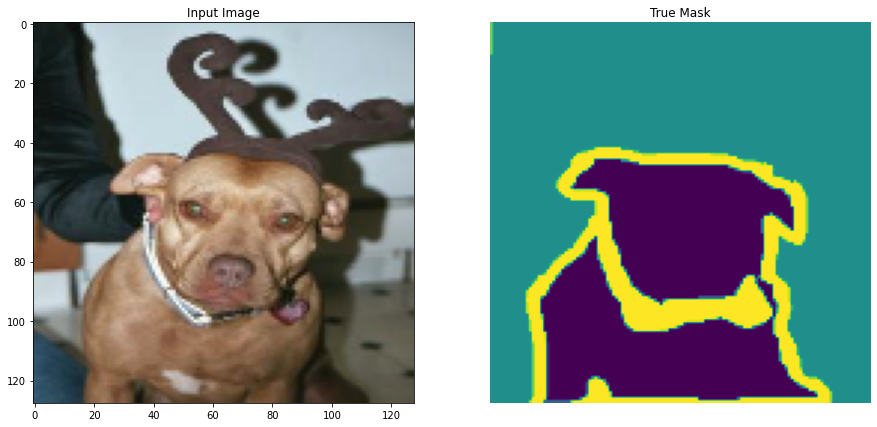

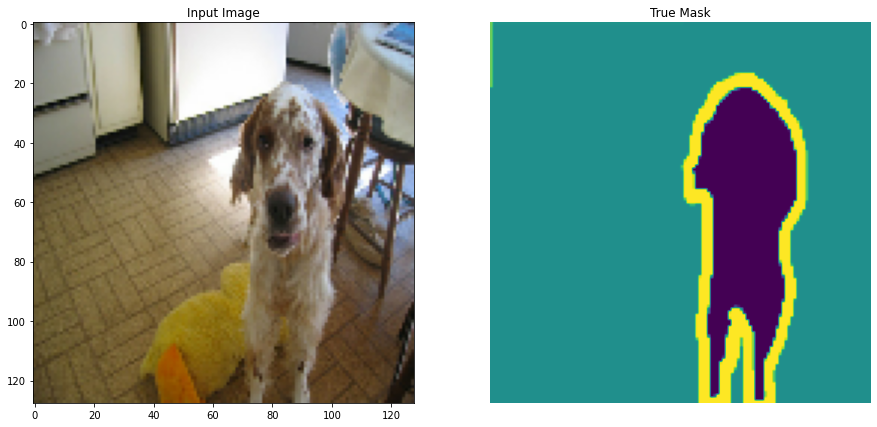

In [10]:
for images, masks in train_batches.take(2):
  sample_image, sample_mask = images[0], masks[0]
  plt.figure(figsize=(15, 15))

  plt.subplot(1, 2, 1)
  plt.title('Input Image')
  plt.imshow(tf.keras.utils.array_to_img(sample_image))
  plt.subplot(1, 2, 2)
  plt.title('True Mask')
  plt.imshow(tf.keras.utils.array_to_img(sample_mask))
  plt.axis('off')
  plt.show()

#Creating the Model

In [11]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

9420800/9406464 [==============================] - 0s 0us/step


In [12]:
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

In [13]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [14]:
inputs = tf.keras.layers.Input(shape=[128, 128, 3])

skips = down_stack(inputs)
x = skips[-1]
skips = reversed(skips[:-1])

for up, skip in zip(up_stack, skips):
  x = up(x)
  concat = tf.keras.layers.Concatenate()
  x = concat([x, skip])

last = tf.keras.layers.Conv2DTranspose(filters=3, kernel_size=3, strides=2, padding='same')  #64x64 -> 128x128

x = last(x)

model = tf.keras.Model(inputs=inputs, outputs=x)

In [15]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#Pre-Training Tests

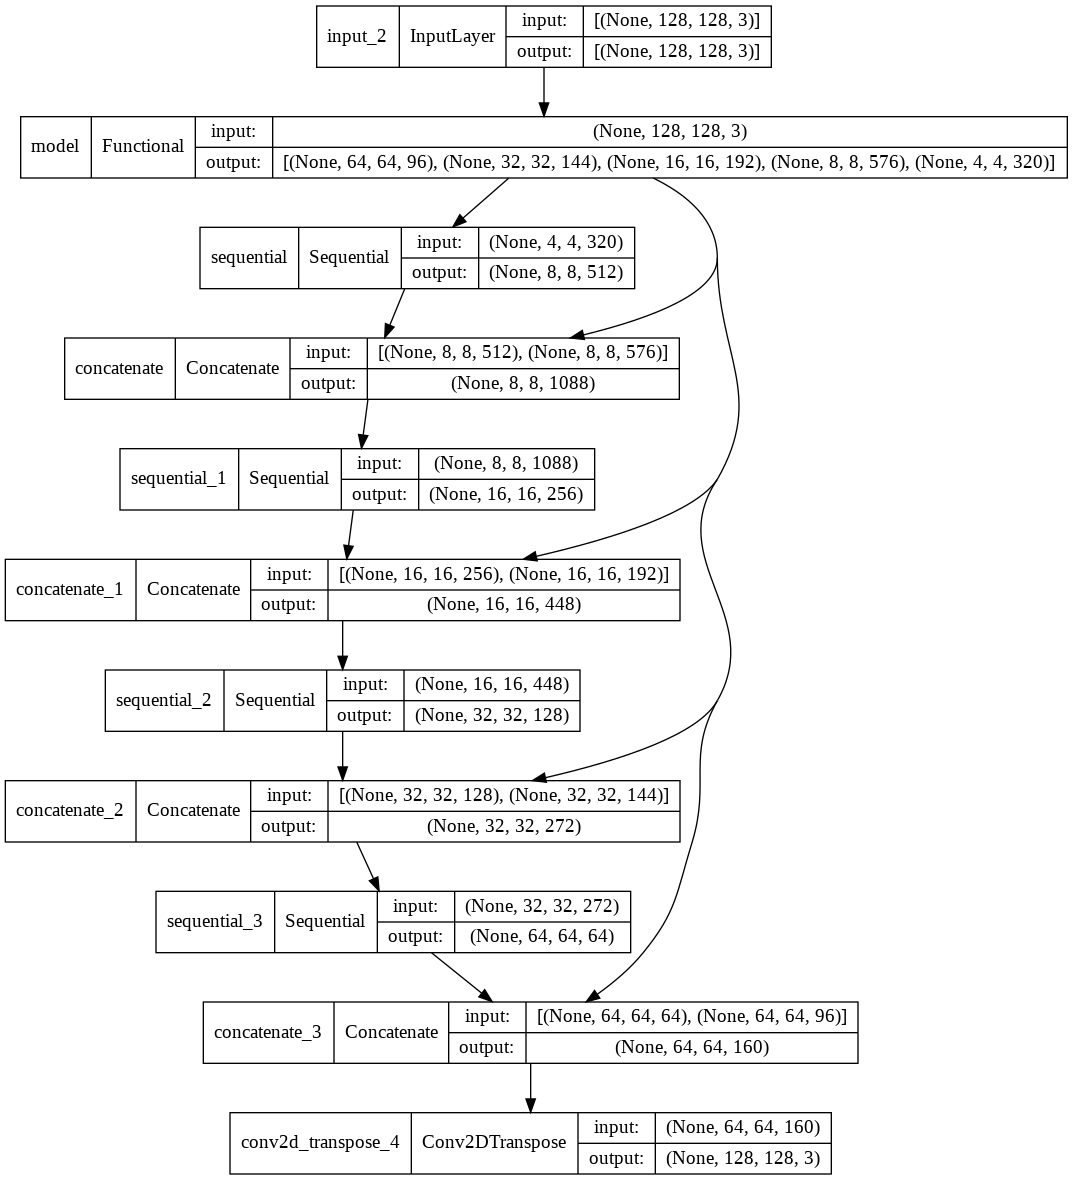

In [16]:
tf.keras.utils.plot_model(model, show_shapes=True)

#Training the Model

In [17]:
model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches)

Epoch 1/20
57/57 [==============================] - 57s 352ms/step - loss: 0.5468 - accuracy: 0.7783 - val_loss: 0.6170 - val_accuracy: 0.7836
Epoch 2/20
57/57 [==============================] - 20s 331ms/step - loss: 0.3039 - accuracy: 0.8765 - val_loss: 0.3251 - val_accuracy: 0.8686
Epoch 3/20
57/57 [==============================] - 19s 329ms/step - loss: 0.2764 - accuracy: 0.8859 - val_loss: 0.2987 - val_accuracy: 0.8786
Epoch 4/20
57/57 [==============================] - 19s 329ms/step - loss: 0.2678 - accuracy: 0.8883 - val_loss: 0.2937 - val_accuracy: 0.8794
Epoch 5/20
57/57 [==============================] - 19s 329ms/step - loss: 0.2547 - accuracy: 0.8929 - val_loss: 0.2768 - val_accuracy: 0.8877
Epoch 6/20
57/57 [==============================] - 19s 328ms/step - loss: 0.2499 - accuracy: 0.8945 - val_loss: 0.2894 - val_accuracy: 0.8818
Epoch 7/20
57/57 [==============================] - 19s 328ms/step - loss: 0.2431 - accuracy: 0.8972 - val_loss: 0.2762 - val_accuracy: 0.8885

In [18]:
model.save('my_model.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


#Inferencing

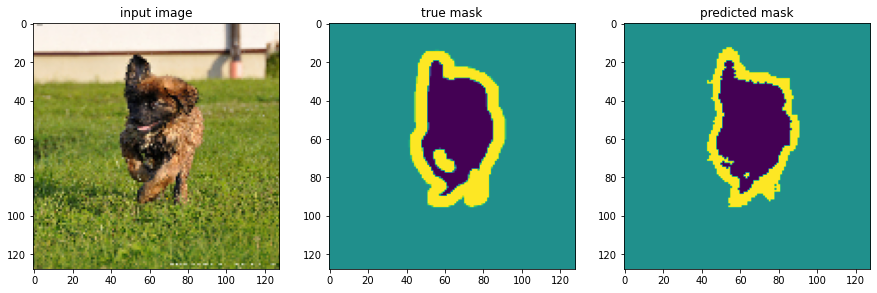

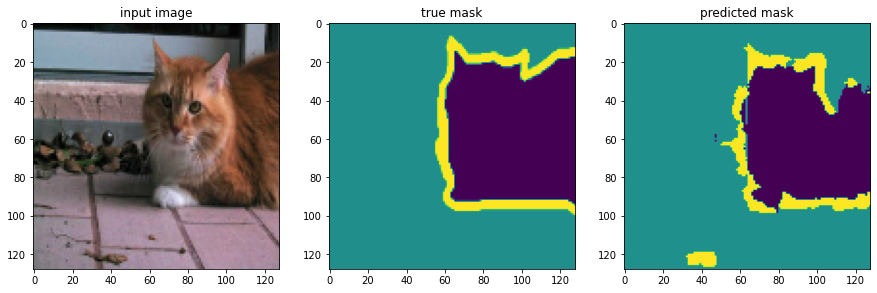

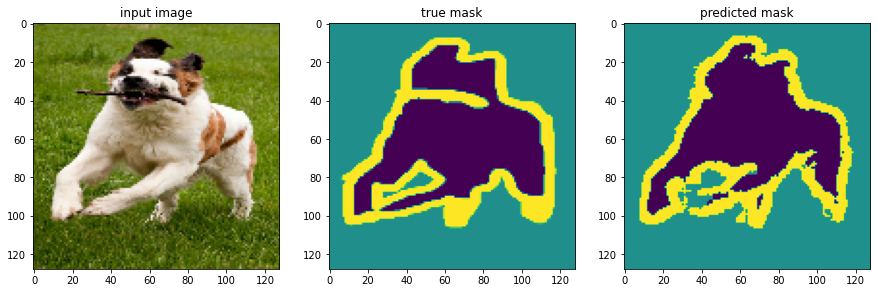

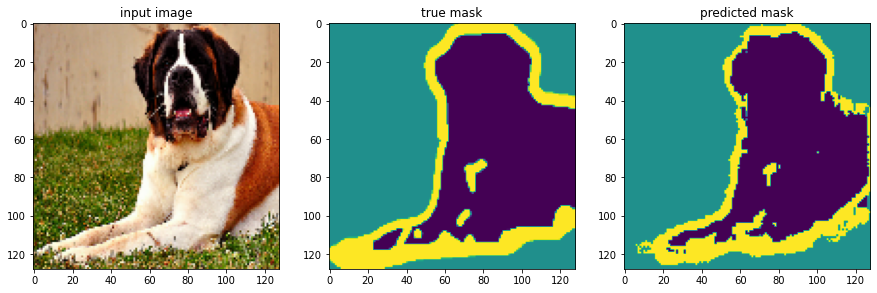

In [39]:
for x in test_batches.take(1):
  input_images = x[0]
  true_masks = x[1]
  predicted_masks = model.predict(x[0])
  
  for i in range(4):
    plt.figure(figsize=(15, 15))
    plt.subplot(1, 3, 1)
    plt.imshow(tf.keras.utils.array_to_img(input_images[i]))
    plt.title('input image')
    plt.subplot(1, 3, 2)
    plt.imshow(tf.keras.utils.array_to_img(true_masks[i]))
    plt.title('true mask')
    plt.subplot(1, 3, 3)
    predicted_mask = tf.argmax(predicted_masks[i], axis=-1)
    predicted_mask = np.array(predicted_mask)
    plt.imshow(predicted_mask)
    plt.title('predicted mask')
    plt.show()